---
title: "强化学习专题 - 价值迭代算法实践"
date: 2025-06-04T03:58:00+08:00
author: "Liu Zheng"
tags: ["笔记", "实验", "AI", "强化学习"]
categories: "实验笔记"
---

# 价值迭代算法实践

## 1. 基本概念

价值迭代（Value Iteration）是一种用于求解马尔可夫决策过程（MDP）最优策略的动态规划算法。其核心思想是通过反复更新每个状态的价值估计，逐步逼近最优状态值函数 $V^*(s)$，进而导出最优策略 $\pi^*(s)$。

价值迭代算法能够高效地找到最优价值函数和最优策略，适用于状态空间较小且模型已知的情形。

> **算法流程**：
> 
> $\begin{array}{l}
>   input:\ \text{MDP}\ = \{ S, A, s_0, P(s' \mid s, a), R(s,a,s') \}\\
>   output:\ \text{Value Function}\ V\\[4mm]
>   \text{Set}\ V\ \text{To Arbitrary Value Function; }\ V(s) = 0\ \text{for all}\ s\\[4mm]
>   repeat\ \\
>   \quad\quad \Delta \leftarrow 0 \\
>   \quad\quad foreach\ s \in S \\
>   \quad\quad\quad\quad V'(s) \leftarrow \max_{a \in A(s)} \sum_{s' \in S}  P(s' \mid s, a)\ [R(s,a,s') + \gamma\ V(s') ] \\
>   \quad\quad\quad\quad \Delta \leftarrow \max(\Delta, |V'(s) - V(s)|) \\
>   \quad\quad V \leftarrow V' \\
>   until\ \Delta \leq \theta 
> \end{array}
> $

## 2. 案例场景

Gymnasium 项目提供了强化学习的各种环境，同时 Pytorch 社区官方推荐使用 TorchRL 强化学习库，因此训练围绕这两个项目进行。

Frozen Lake 场景作为基础的方格游戏，比较适合使用价值迭代算法训练。

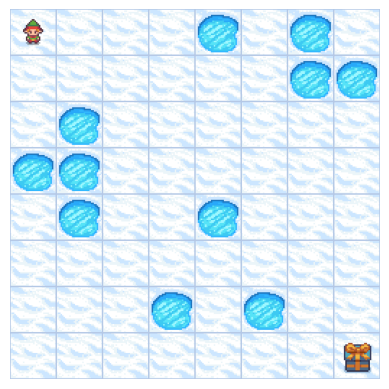

In [1]:
import gymnasium
import matplotlib.pyplot
import numpy
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

SIZE = 8

ENV = gymnasium.make("FrozenLake-v1", desc=generate_random_map(SIZE), map_name=f"{SIZE}x{SIZE}", is_slippery=False, render_mode="rgb_array")
ENV.reset()

image = ENV.render()

matplotlib.pyplot.imshow(image)
matplotlib.pyplot.axis("off")
matplotlib.pyplot.show()

**随机生成的世界总是会有一条通往目标点的路径。**

### 2.1. 场景说明

- 游戏的起始点是冰冻湖网格世界的 `[0,0]` 位置，目标点位于世界的远端，例如 `4x4` 环境中的 `[3,3]`。
- 冰面上的**冰窟**分布在固定的位置（如果使用预设地图）或随机的位置（如果生成随机地图）。
- 玩家持续移动，直到他们到达**目标点**或**掉进冰窟**。
- 湖面很**滑**（除非禁用此特性），所以玩家有时可能会**垂直于预期方向移动**（参见 `is_slippery`）。

### 2.2. 动作空间（action_space）

动作空间是一个形状为 `(1,)` 的数组，其取值范围在 `{0, 3}` 之间，表示玩家的移动方向：

- **0**: 向左移动
- **1**: 向下移动
- **2**: 向右移动
- **3**: 向上移动

### 2.3. 状态空间（state_space）

观测值是一个整数，表示玩家当前的位置，计算方式是 **`当前行 * 列数 + 当前列`**（行和列都从 0 开始计数）。

举个例子，在 4x4 的地图中，目标位置的观测值可以这样计算：`3 * 4 + 3 = 15`。可能的观测值数量取决于地图的大小。

观测值以 **`.int()`** 形式返回。

游戏开始时，玩家位于状态 0（即 [0,0] 位置）。

### 2.4. 奖励机制

- **到达目标**：+1 分
- **掉入冰窟**：0 分
- **停留冰面**：0 分

### 2.5. 结束条件

剧集在以下情况发生时结束：

- **终止**：
    - 玩家掉入冰窟。
    - 玩家到达目标位置（`max(nrow) * max(ncol) - 1`，即 `[max(nrow)-1, max(ncol)-1]` 位置）。
- **截断**（使用 `time_limit` 包装器时）：
    - 对于 4x4 环境，剧集长度为 100 步。
    - 对于 `FrozenLake8x8-v1` 环境，剧集长度为 200 步。

### 2.6. 其他信息

`step()` 和 `reset()` 方法会返回一个字典，其中包含以下键值：

- **`p`**：状态转移概率。

有关转移概率的更多信息，请参阅 `is_slippery`。


## 3. 案例实现

In [ ]:
class MDP:
    def __init__(self, env):
        self.env = env
        self.S = range(env.observation_space.n)
        self.A = range(env.action_space.n)
        self.V = numpy.zeros(env.observation_space.n)  # Initialize the value function for each state to zero
        self.Pi = numpy.zeros(env.observation_space.n, dtype=int)  # Initialize the policy to zero (arbitrary action)

    # Value Iteration algorithm to find the optimal policy and value function
    def build(self, gamma=0.99, theta=1e-8):
        while True:
            delta = 0  # Used to measure the maximum change in value function
            for s in self.S:
                v = self.V[s]
                Q = numpy.zeros(self.env.action_space.n)
                for a in self.A:
                    # env.unwrapped.P[s][a] contains (probability, next_state, reward, terminated) tuples
                    for Psa, sn, Rsa, terminated in self.env.unwrapped.P[s][a]:
                        # Bellman Optimality Equation update for Value Iteration
                        # Q(s,a) = sum_{s',r} P(s',r|s,a) * [r + gamma * V(s')]
                        Q[a] += Psa * (Rsa + gamma * self.V[sn])
                self.V[s] = numpy.max(Q)  # Update the value of state 's' to be the maximum Q-value among all actions
                delta = max(delta, abs(v - self.V[s]))  # Update the maximum change
                self.Pi[s] = numpy.argmax(Q)  # Choose the action with the maximum Q-value
            if delta < theta:  # Check for convergence
                break
        return self.V, self.Pi

    def decision(self, s):
        return self.Pi[s], self.V[s]

    def evaluate(self, figure):
        # Mapping actions to arrow symbols: 0: LEFT, 1: DOWN, 2: RIGHT, 3: UP
        arrows = {0: "\u2190", 1: "\u2193", 2: "\u2192", 3: "\u2191"}
        image = self.env.render()
        subplot = figure.add_subplot()
        subplot.axis("off")
        subplot.imshow(image)
        ih, iw, _ = image.shape
        ch, cw = ih // SIZE, iw // SIZE  # Cell height and width
        s, _ = self.env.reset()
        for i in range(SIZE):
            for j in range(SIZE):
                a, q = self.decision(i * SIZE + j)
                subplot.text(j * cw + cw - 12, i * ch + 12, arrows[a], fontsize=10, ha="center", va="center", fontfamily="Sarasa Mono SC")
                subplot.text(j * cw + 24, i * ch + ch - 12, f"{q:.2f}", fontsize=10, ha="center", va="center", fontfamily="Sarasa Mono SC")
        while True:
            a, _ = self.decision(s)
            s, reward, done, truncated, _ = self.env.step(a)
            if done or truncated:
                break
            subplot.plot(s % SIZE * cw + cw // 2, s // SIZE * ch + ch // 2, marker="o", markersize=8, color="red", alpha=0.5)
        matplotlib.pyplot.show()

    def simulation(self, epis=1000):
        count = 0
        for episode in range(epis):
            s, _ = self.env.reset()
            done = False
            truncated = False
            R = 0
            while not done and not truncated:
                a, _ = self.decision(s)
                s, Rs, done, truncated, _ = self.env.step(a)
                R += Rs
                if done and Rs == 1.0:  # In FrozenLake, reward is 1.0 only upon reaching 'G'
                    count += 1
        success_rate = count / epis * 100
        print(f"\nRunning {epis} episodes using the optimal policy:")
        print(f"Success Rate: {success_rate:.2f}%")

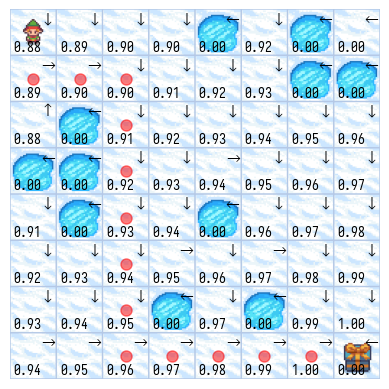


Running 100 episodes using the optimal policy:
Success Rate: 100.00%


In [3]:
INSTANCE = MDP(ENV)

INSTANCE.build(gamma=0.99, theta=1e-8)
INSTANCE.evaluate(matplotlib.pyplot.figure())
INSTANCE.simulation(100)

ENV.close()